In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.neural_network import MLPRegressor
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from PredictXANES import xanes_derivatives

In [3]:
def split_data(df):
    '''
    The spectra are split into a training set and 
    testing set with a ratio of 4:1. The predicted features are the coordination number, 
    number of Cu atoms, and number of Te atoms.
    '''
    
    X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
    list = X.columns.tolist()

    X.columns = range(X.shape[1])
    X.columns = list
   
    y = df[['CN', 'Num Cu', 'Num Te']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=412)
    
    return X_train, X_test, y_train, y_test, X, y

def derivatives(X):
    '''
    derivatives returns the first, second, and combined first and second derivitive dataframes
    '''
    d1, d2 = xanes_derivatives.xanes_derivatives(X)
    df1 = pd.DataFrame(d1)
    df2 = pd.DataFrame(d2)
    df3 = pd.concat([df1, df2], axis=1)

    return df1, df2, df3
    
def train(X_train, y_train):
    '''
    train_layer trains the neural network. One layer is added, and the depth of the that layer is optimized by 
    looking at the loss from a range of 1 to 100, the maximum number of features being trained on.
    '''
    
    loss = []
    for i in range(100):
        if i == 0:
            pass
        else:
            nn = MLPRegressor(hidden_layer_sizes=(i), activation='identity', solver='lbfgs', max_iter=2000, random_state=28)
            nn = nn.fit(X_train, y_train)
            loss.append(nn.loss_)

    lossdf = pd.DataFrame(loss)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(lossdf)
    return lossdf, nn

def analyse_layer(X_train, X_test, y_train, y_test, nn):
    '''
    analyse_layer returns the training mse and r2 values for the layer in the neural network
    '''
    
    y_train_pred = nn.predict(X_train)
    y_test_pred = nn.predict(X_test)
    train_score_CN = r2_score(y_train.iloc[:,0], y_train_pred[:,0])
    train_score_Cu = r2_score(y_train.iloc[:,1], y_train_pred[:,1]) 
    train_score_Te = r2_score(y_train.iloc[:,2], y_train_pred[:,2])
    test_score_CN = r2_score(y_test.iloc[:,0], y_test_pred[:,0])
    test_score_Cu = r2_score(y_test.iloc[:,1], y_test_pred[:,1])
    test_score_Te = r2_score(y_test.iloc[:,2], y_test_pred[:,2])
    train_mse_CN = mean_squared_error(y_train.iloc[:,0], y_train_pred[:,0])
    train_mse_Cu = mean_squared_error(y_train.iloc[:,1], y_train_pred[:,1])
    train_mse_Te = mean_squared_error(y_train.iloc[:,2], y_train_pred[:,2])
    test_mse_CN = mean_squared_error(y_test.iloc[:,0], y_test_pred[:,0])
    test_mse_Cu = mean_squared_error(y_test.iloc[:,1], y_test_pred[:,1])
    test_mse_Te = mean_squared_error(y_test.iloc[:,2], y_test_pred[:,2])

    train_score_list = [train_score_CN, train_score_Cu, train_score_Te]
    train_mse_list = [train_mse_CN, train_mse_Cu, train_mse_Te]
    test_mse_list = [test_mse_CN, train_mse_Cu, train_mse_Te]
    test_score_list = [test_score_CN, test_score_Cu, test_score_Te]
    print('training mse =  '+ str(train_mse_list))
    print('testing mse = ' + str(test_mse_list))
    print('training R2 = ' + str(train_score_list))
    print('testing R2 = ' + str(test_score_list))
    
    return test_mse_list, test_score_list, y_test_pred

def append_layer_to_list(test_mse_list, test_score_list, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list):
    '''
    append_layer_to_list takes the mse and score lists and appends them to a list for plotting erros vs noise, 
    note that here mse is converted to rmse
    '''
    
    rmse_CN = np.sqrt(test_mse_list[0])
    rmse_CN_master_list.append(rmse_CN)
    rmse_Cu = np.sqrt(test_mse_list[1])
    rmse_Cu_master_list.append(rmse_Cu)
    rmse_Te = np.sqrt(test_mse_list[2])
    rmse_Te_master_list.append(rmse_Te)
    
    score_CN = test_score_list[0]
    score_CN_master_list.append(score_CN)
    score_Cu = test_score_list[1]
    score_Cu_master_list.append(score_Cu)
    score_Te = test_score_list[2]
    score_Te_master_list.append(score_Te)

def plot_parity(y_test, y_test_pred):
    '''
    plot_parity is a function to generate parity plots for the layer to check performance for predicting 
    coordination number, number of nearest Te atoms, and number of nearest Cu atoms.
    '''
    x1 = np.linspace(8, 12, 50)
    x2 = np.linspace(4, 8, 50)
    x3 = np.linspace(4, 5, 50)

    plt.figure(figsize=[14,4])
    plt.subplots_adjust(wspace=0.3)
    ax1 = plt.subplot(1,3,1)
    ax1.scatter(y_test.iloc[:,0], y_test_pred[:,0])
    ax1.plot(x1, x1, color='red')
    ax1.set_xlabel('True CN')
    ax1.set_ylabel('Pred CN')
    ax1.set_title('Test CN')
    plt.axis('equal')

    ax2 = plt.subplot(1,3,2)
    ax2.scatter(y_test.iloc[:,1], y_test_pred[:,1])
    ax2.plot(x2, x2, color='red')
    ax2.set_xlabel('True Cu Num')
    ax2.set_ylabel('Pred Cu Num')
    ax2.set_title('Test Cu Num')
    plt.axis('equal')


    ax3 = plt.subplot(1,3,3)
    ax3.scatter(y_test.iloc[:,2], y_test_pred[:,2])
    ax3.plot(x3, x3, color='red')
    ax3.set_xlabel('True Te Num')
    ax3.set_ylabel('Pred Te Num')
    ax3.set_title('Test Te Num')
    plt.axis('equal')
    
    
def run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list):
    '''
    run_layer is a wrapper function that executes the training, testing, analysis, and plotting for a 
    single layer of the neural network
    '''
    lossdf, nn = train(X_train, y_train)
    test_mse_list, test_score_list, y_test_pred = analyse_layer(X_train, X_test, y_train, y_test, nn) #series from dataframe
    append_layer_to_list(test_mse_list, test_score_list, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)
    plot_parity(y_test, y_test_pred)

def MLP_per_set_size(df, rmse_CN_master_list, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for spectrum
    '''
    for entry in Noise_STD:
        print('set size: ', entry)
        X_train, X_test, y_train, y_test, X, y = split_data(df)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)
    print(rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

def MLP_per_set_size_1(df, set_size, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1):
    '''
    MLP_per_noise_1 is a wrapper function that runs a layer of neural network per level of noise for the first derivative
    '''
    for entry in set_size:
        print('set size: ', entry)
        _, _, _, _, X, y = split_data(df)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df1, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)
    print(rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)

def MLP_per_set_size_2(df, set_size, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for the second derivative
    '''
    for entry in set_size:
        print('set size: ', entry)
        _, _, _, _, X, y = split_data(df)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df2, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)
    print(rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)
    
    
def MLP_per_set_size_1_2(df, set_size, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for both the first and second derivative
    '''
    for entry in set_size:
        print('set size: ', entry)
        _, _, _, _, X, y = split_data(df)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df3, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)
    print(rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)


Data import of 10,000 calculated average XANES spectra along with averaged coordination numbers, number of Cu atoms within 3 angstroms, and number of Te atoms within 3 angstroms.

In [4]:
df = pd.read_csv('mu_cn10000.csv')

## Spectra Only:

Create lists for plotting noise vs R2 an RMSE

In [5]:
size_list = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
rmse_CN_master_list = []
score_CN_master_list = []
rmse_Cu_master_list = []
score_Cu_master_list = []
rmse_Te_master_list = []
score_Te_master_list = []

set size:  500
           0
0   0.008776
1   0.001882
2   0.001816
3   0.001670
4   0.001628
5   0.001806
6   0.001546
7   0.001373
8   0.001771
9   0.001834
10  0.001384
11  0.001775
12  0.001835
13  0.001258
14  0.001191
15  0.001821
16  0.001818
17  0.001423
18  0.001737
19  0.001712
20  0.001422
21  0.001820
22  0.001413
23  0.001758
24  0.001693
25  0.001795
26  0.001769
27  0.001492
28  0.001689
29  0.001804
30  0.001803
31  0.001441
32  0.001282
33  0.001733
34  0.001778
35  0.001318
36  0.001355
37  0.001777
38  0.001772
39  0.001762
40  0.001370
41  0.001761
42  0.001724
43  0.001779
44  0.001633
45  0.001771
46  0.001803
47  0.001829
48  0.001839
49  0.001795
50  0.001847
51  0.001753
52  0.001883
53  0.001406
54  0.001229
55  0.001781
56  0.001357
57  0.001671
58  0.001794
59  0.001215
60  0.001202
61  0.001742
62  0.001837
63  0.001674
64  0.001383
65  0.001737
66  0.001796
67  0.001768
68  0.001289
69  0.001753
70  0.001756
71  0.001276
72  0.001839
73  0.001750
74  0.0018

           0
0   0.008776
1   0.001882
2   0.001816
3   0.001670
4   0.001628
5   0.001806
6   0.001546
7   0.001373
8   0.001771
9   0.001834
10  0.001384
11  0.001775
12  0.001835
13  0.001258
14  0.001191
15  0.001821
16  0.001818
17  0.001423
18  0.001737
19  0.001712
20  0.001422
21  0.001820
22  0.001413
23  0.001758
24  0.001693
25  0.001795
26  0.001769
27  0.001492
28  0.001689
29  0.001804
30  0.001803
31  0.001441
32  0.001282
33  0.001733
34  0.001778
35  0.001318
36  0.001355
37  0.001777
38  0.001772
39  0.001762
40  0.001370
41  0.001761
42  0.001724
43  0.001779
44  0.001633
45  0.001771
46  0.001803
47  0.001829
48  0.001839
49  0.001795
50  0.001847
51  0.001753
52  0.001883
53  0.001406
54  0.001229
55  0.001781
56  0.001357
57  0.001671
58  0.001794
59  0.001215
60  0.001202
61  0.001742
62  0.001837
63  0.001674
64  0.001383
65  0.001737
66  0.001796
67  0.001768
68  0.001289
69  0.001753
70  0.001756
71  0.001276
72  0.001839
73  0.001750
74  0.001829
75  0.001230

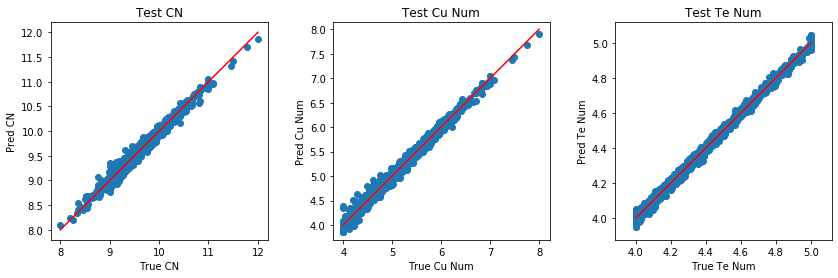

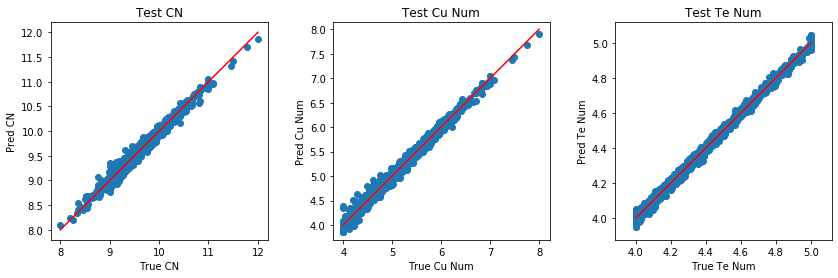

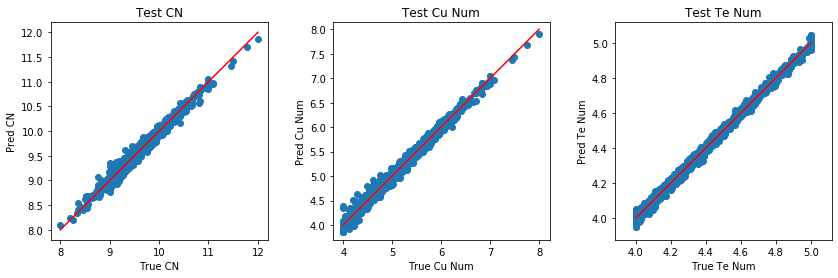

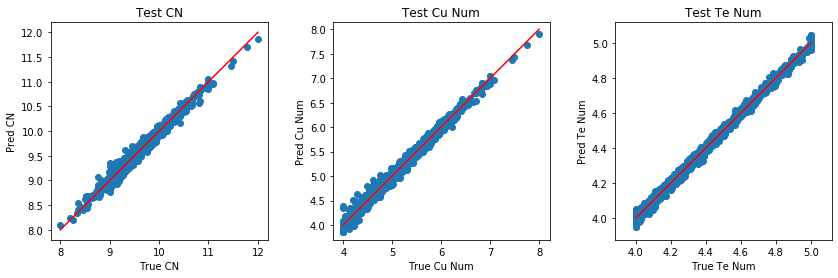

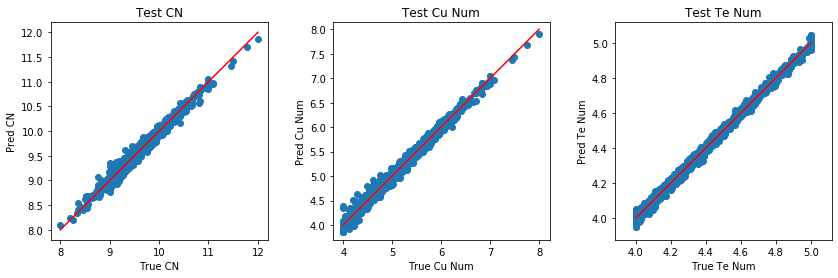

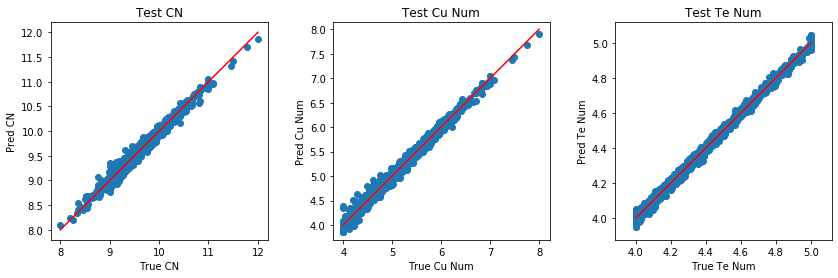

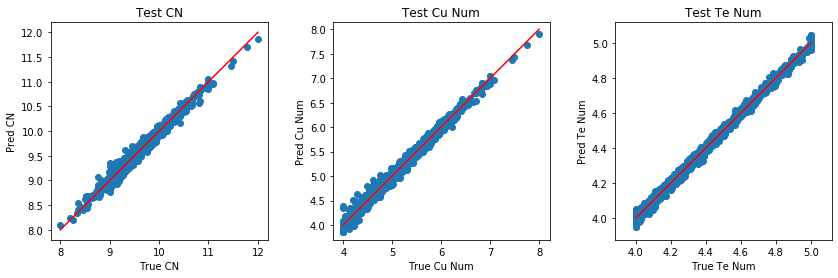

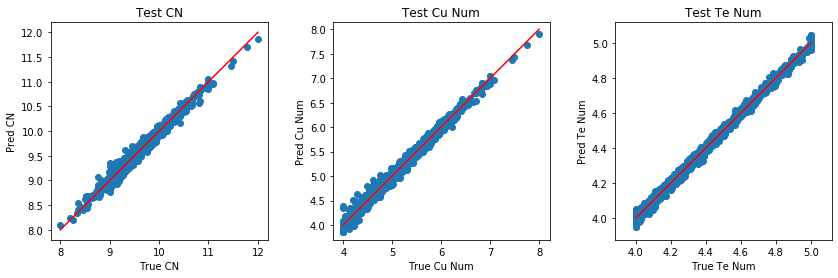

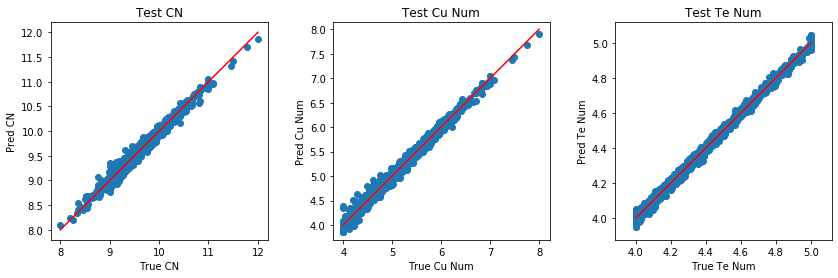

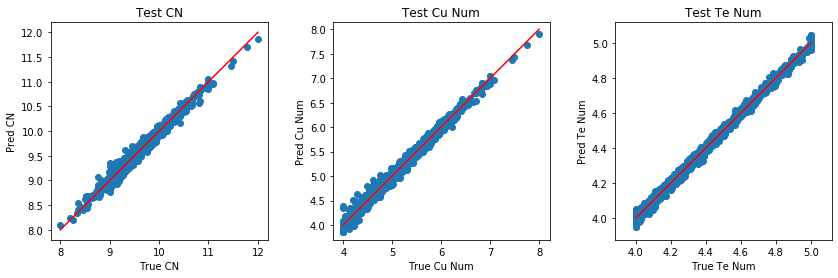

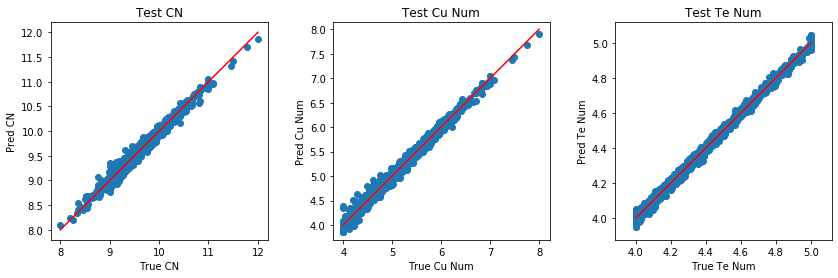

In [6]:
MLP_per_set_size(df, size_list, rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list)

# Repeated for training with first derivative.

In [7]:
size_list = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
rmse_CN_master_list_1 = []
score_CN_master_list_1 = []
rmse_Cu_master_list_1 = []
score_Cu_master_list_1 = []
rmse_Te_master_list_1 = []
score_Te_master_list_1 = []

set size:  500
           0
0   0.007549
1   0.000438
2   0.000550
3   0.000414
4   0.000430
5   0.000461
6   0.000428
7   0.000406
8   0.000459
9   0.000374
10  0.000453
11  0.000598
12  0.000634
13  0.000431
14  0.000573
15  0.000421
16  0.000510
17  0.000444
18  0.000403
19  0.000517
20  0.000387
21  0.000470
22  0.000470
23  0.000621
24  0.000414
25  0.000677
26  0.001037
27  0.000431
28  0.000912
29  0.000418
30  0.000878
31  0.000535
32  0.000731
33  0.000484
34  0.000928
35  0.000661
36  0.000431
37  0.000950
38  0.000600
39  0.000749
40  0.000449
41  0.000397
42  0.000669
43  0.000749
44  0.000713
45  0.000648
46  0.000358
47  0.000945
48  0.001027
49  0.000550
50  0.000999
51  0.000469
52  0.000531
53  0.001005
54  0.000515
55  0.000973
56  0.000625
57  0.000977
58  0.000650
59  0.000973
60  0.000479
61  0.000690
62  0.000970
63  0.000870
64  0.000957
65  0.000889
66  0.000861
67  0.000716
68  0.000731
69  0.000980
70  0.000603
71  0.000996
72  0.000657
73  0.001002
74  0.0006

           0
0   0.007622
1   0.000497
2   0.000511
3   0.000601
4   0.000588
5   0.000437
6   0.000450
7   0.000538
8   0.000735
9   0.000415
10  0.000380
11  0.000616
12  0.000937
13  0.000439
14  0.000705
15  0.000404
16  0.000418
17  0.000473
18  0.000839
19  0.000453
20  0.000478
21  0.000619
22  0.000505
23  0.000987
24  0.000423
25  0.000997
26  0.000592
27  0.000955
28  0.000780
29  0.000526
30  0.000972
31  0.001013
32  0.000858
33  0.000960
34  0.000611
35  0.000481
36  0.000527
37  0.000885
38  0.000942
39  0.000478
40  0.000675
41  0.000656
42  0.000730
43  0.000934
44  0.000729
45  0.000452
46  0.000977
47  0.001046
48  0.000735
49  0.000424
50  0.000499
51  0.000570
52  0.000635
53  0.001005
54  0.000776
55  0.000993
56  0.000986
57  0.000937
58  0.000992
59  0.000668
60  0.000759
61  0.000956
62  0.000421
63  0.000479
64  0.000933
65  0.000983
66  0.000638
67  0.000965
68  0.000974
69  0.000951
70  0.000936
71  0.000500
72  0.000710
73  0.000533
74  0.000987
75  0.000993

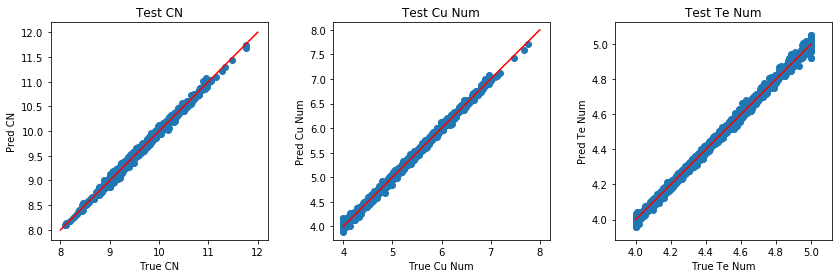

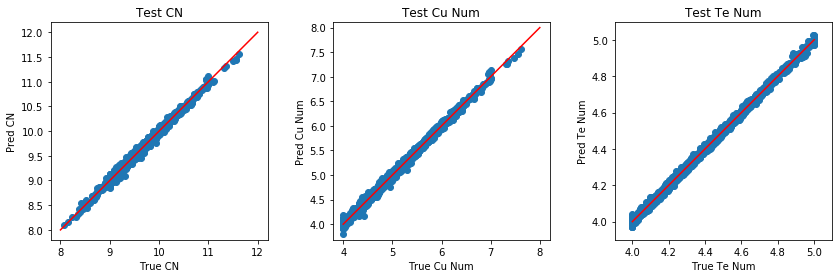

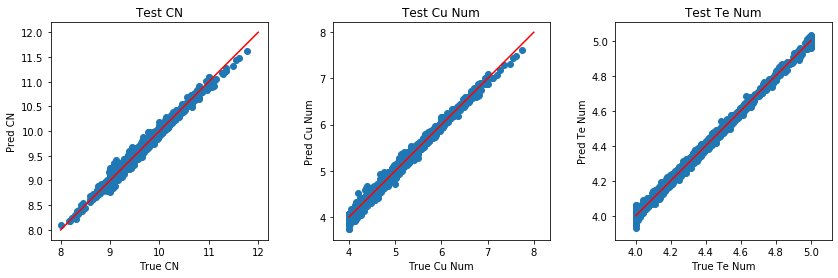

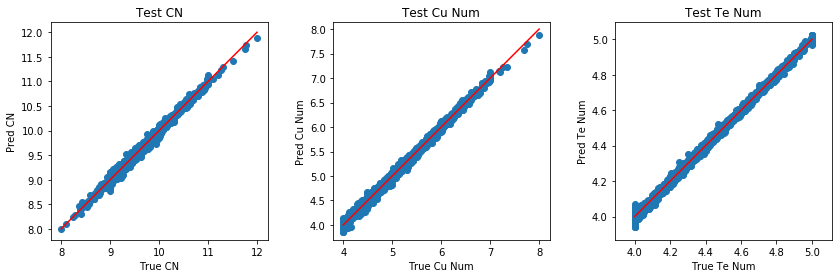

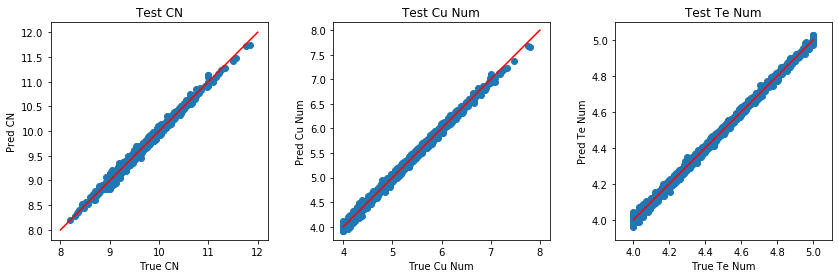

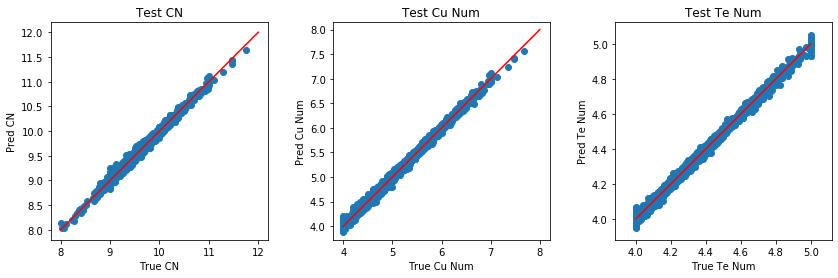

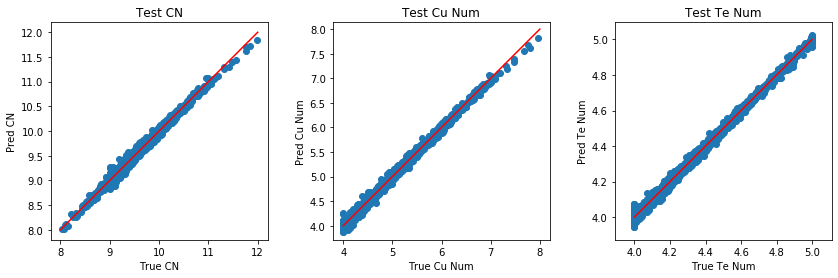

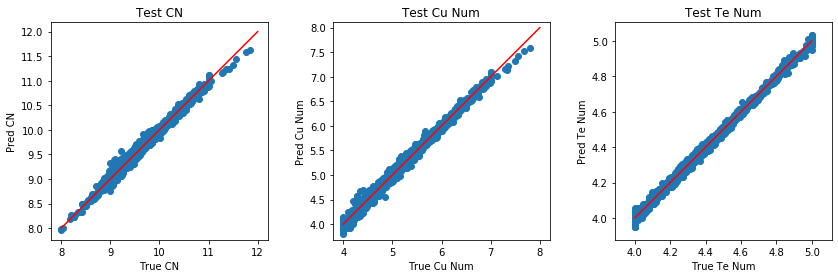

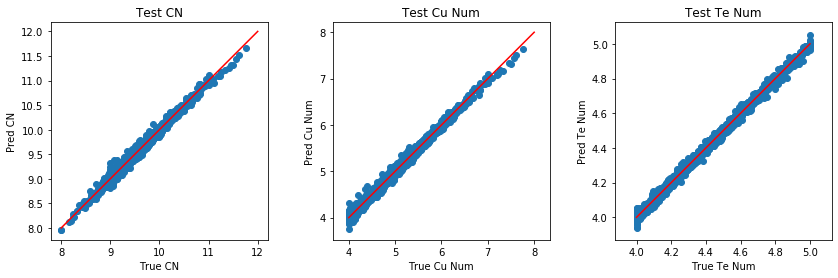

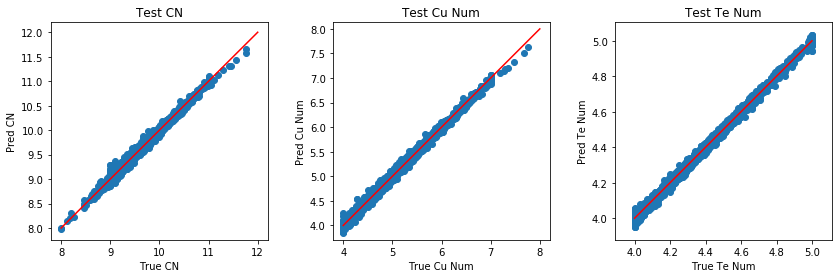

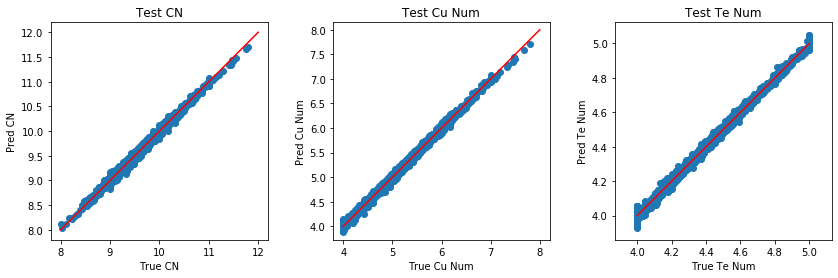

In [8]:
MLP_per_set_size_1(df, size_list, rmse_CN_master_list_1, score_CN_master_list_1, rmse_Cu_master_list_1, score_Cu_master_list_1, rmse_Te_master_list_1, score_Te_master_list_1)

# Repeated for training with both the first and second derivative.

In [9]:
size_list = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
rmse_CN_master_list_1_2 = []
score_CN_master_list_1_2 = []
rmse_Cu_master_list_1_2 = []
score_Cu_master_list_1_2 = []
rmse_Te_master_list_1_2 = []
score_Te_master_list_1_2 = []

set size:  500
           0
0   0.007379
1   0.000355
2   0.000416
3   0.000385
4   0.000379
5   0.000334
6   0.000361
7   0.000321
8   0.000335
9   0.000387
10  0.000349
11  0.000396
12  0.000333
13  0.000424
14  0.000337
15  0.000320
16  0.000337
17  0.000586
18  0.000362
19  0.000520
20  0.000346
21  0.000355
22  0.000512
23  0.000453
24  0.000425
25  0.000335
26  0.000378
27  0.000444
28  0.000543
29  0.000586
30  0.000470
31  0.000528
32  0.000517
33  0.000567
34  0.000508
35  0.000415
36  0.000537
37  0.000617
38  0.000577
39  0.001132
40  0.000559
41  0.000316
42  0.000427
43  0.000558
44  0.000445
45  0.000418
46  0.000339
47  0.000440
48  0.000411
49  0.000534
50  0.000518
51  0.000442
52  0.000510
53  0.000488
54  0.001101
55  0.000452
56  0.000511
57  0.000460
58  0.000551
59  0.000628
60  0.000593
61  0.001021
62  0.000601
63  0.000415
64  0.001046
65  0.000495
66  0.000553
67  0.000581
68  0.001104
69  0.000573
70  0.000569
71  0.000472
72  0.001181
73  0.000592
74  0.0005

           0
0   0.007647
1   0.000424
2   0.000355
3   0.000542
4   0.000379
5   0.000330
6   0.000367
7   0.000354
8   0.000416
9   0.000365
10  0.000351
11  0.000426
12  0.000426
13  0.000323
14  0.000471
15  0.000480
16  0.000428
17  0.000336
18  0.000466
19  0.000390
20  0.000374
21  0.000394
22  0.000530
23  0.000426
24  0.000399
25  0.000488
26  0.000448
27  0.000432
28  0.000485
29  0.000548
30  0.000458
31  0.000426
32  0.000452
33  0.000457
34  0.001003
35  0.000411
36  0.000652
37  0.000534
38  0.000525
39  0.000449
40  0.000545
41  0.000446
42  0.000511
43  0.000557
44  0.000597
45  0.000538
46  0.000521
47  0.000446
48  0.000476
49  0.000560
50  0.000448
51  0.000543
52  0.000498
53  0.000432
54  0.000667
55  0.000623
56  0.001032
57  0.000542
58  0.000609
59  0.000429
60  0.000504
61  0.000457
62  0.000440
63  0.000483
64  0.001052
65  0.000539
66  0.000555
67  0.000558
68  0.000969
69  0.000456
70  0.000504
71  0.001185
72  0.000553
73  0.000554
74  0.000652
75  0.000514

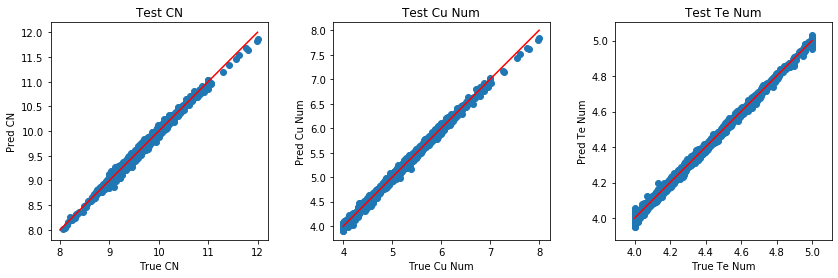

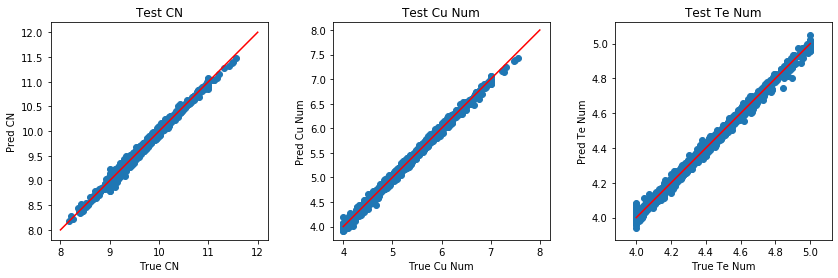

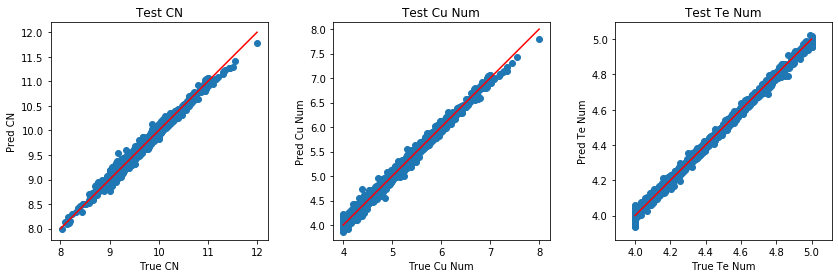

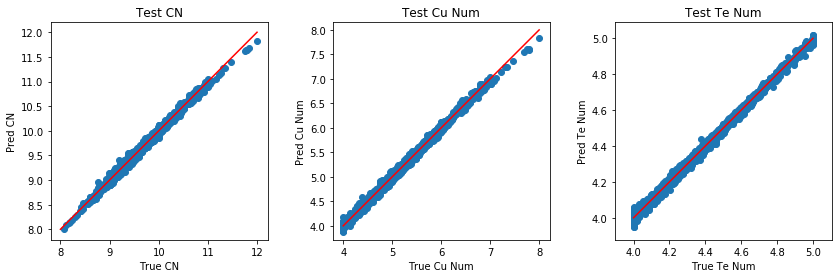

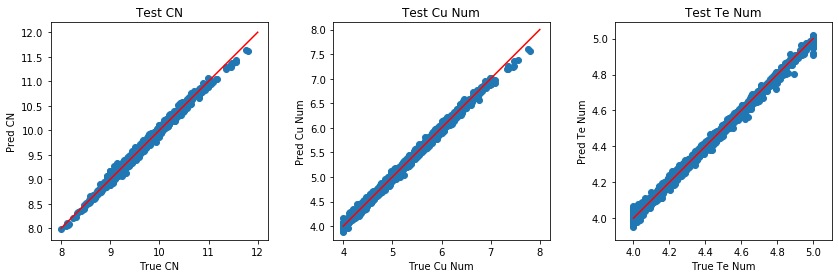

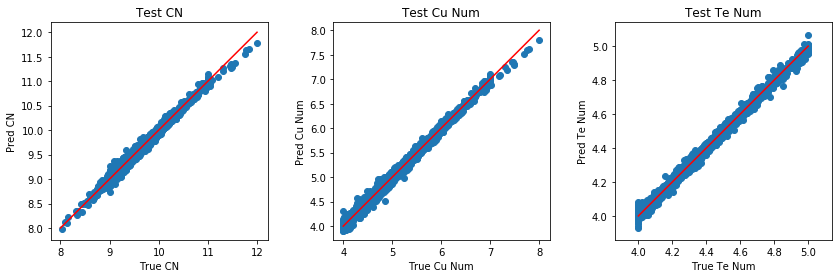

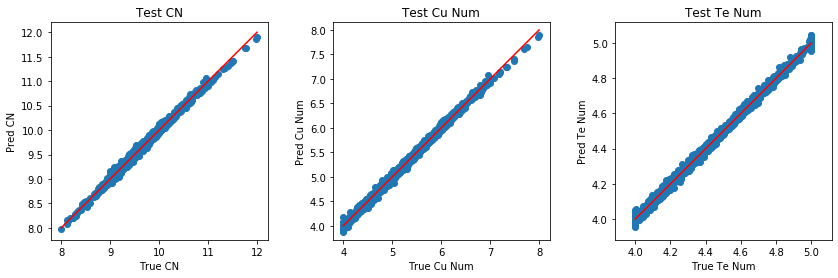

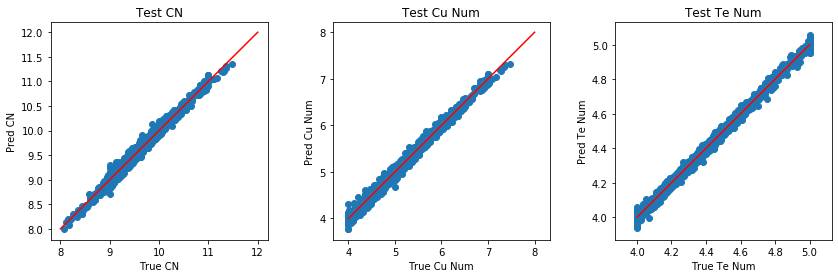

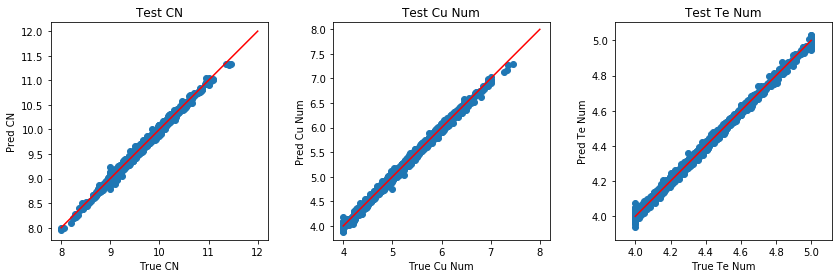

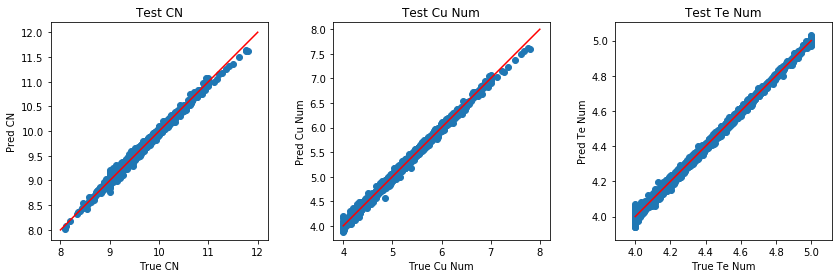

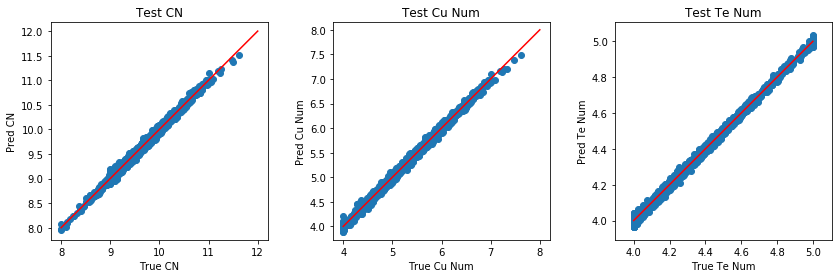

In [10]:
MLP_per_set_size_1_2(df, size_list, rmse_CN_master_list_1_2, score_CN_master_list_1_2, rmse_Cu_master_list_1_2, score_Cu_master_list_1_2, rmse_Te_master_list_1_2, score_Te_master_list_1_2)

In [11]:
print(rmse_CN_master_list_1_2)

[0.040548718036682856, 0.04039047715212472, 0.056190535171479046, 0.04101334790457366, 0.04160267403478968, 0.05350445479004049, 0.035784043930811624, 0.05466468837026138, 0.03920677212555441, 0.039806114031684485, 0.041429406658754074]


In [12]:
size_list = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
rmse_CN_master_list_2 = []
score_CN_master_list_2 = []
rmse_Cu_master_list_2 = []
score_Cu_master_list_2 = []
rmse_Te_master_list_2 = []
score_Te_master_list_2 = []

set size:  500
           0
0   0.007841
1   0.000739
2   0.000922
3   0.000891
4   0.001152
5   0.001134
6   0.000841
7   0.000825
8   0.000946
9   0.000963
10  0.000927
11  0.000901
12  0.000899
13  0.000938
14  0.001055
15  0.000949
16  0.000801
17  0.000764
18  0.000804
19  0.001146
20  0.000994
21  0.000863
22  0.000818
23  0.000798
24  0.000917
25  0.000915
26  0.000843
27  0.001139
28  0.001037
29  0.000793
30  0.000791
31  0.000895
32  0.000903
33  0.001160
34  0.001001
35  0.001029
36  0.001090
37  0.000760
38  0.000879
39  0.000969
40  0.001540
41  0.001354
42  0.001119
43  0.000975
44  0.001646
45  0.001002
46  0.000966
47  0.001074
48  0.000867
49  0.000759
50  0.000856
51  0.000819
52  0.001081
53  0.000980
54  0.000925
55  0.001531
56  0.000937
57  0.001129
58  0.000763
59  0.000880
60  0.000853
61  0.000893
62  0.001033
63  0.001042
64  0.001222
65  0.001438
66  0.000894
67  0.001120
68  0.001056
69  0.001030
70  0.000821
71  0.001060
72  0.000793
73  0.000994
74  0.0012

           0
0   0.007693
1   0.001254
2   0.001100
3   0.001012
4   0.001184
5   0.000869
6   0.000922
7   0.001097
8   0.001074
9   0.000891
10  0.000835
11  0.001022
12  0.001037
13  0.001044
14  0.001097
15  0.001078
16  0.001219
17  0.000889
18  0.000778
19  0.001063
20  0.001424
21  0.001075
22  0.001161
23  0.000741
24  0.000814
25  0.000904
26  0.001138
27  0.000858
28  0.001011
29  0.000945
30  0.000885
31  0.000949
32  0.000970
33  0.001305
34  0.000954
35  0.000847
36  0.001262
37  0.001057
38  0.000857
39  0.001524
40  0.001668
41  0.001335
42  0.000931
43  0.001468
44  0.000851
45  0.001192
46  0.001443
47  0.001090
48  0.000778
49  0.001057
50  0.000894
51  0.000788
52  0.001339
53  0.001250
54  0.001380
55  0.001100
56  0.000913
57  0.001422
58  0.000694
59  0.001503
60  0.001164
61  0.000969
62  0.001059
63  0.001334
64  0.000983
65  0.000851
66  0.001103
67  0.001026
68  0.001037
69  0.000839
70  0.001639
71  0.000865
72  0.001350
73  0.001554
74  0.000908
75  0.001574

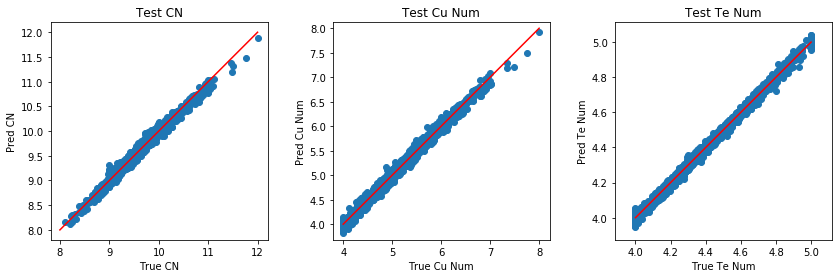

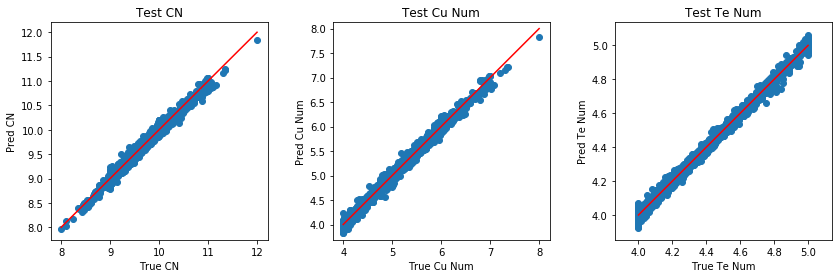

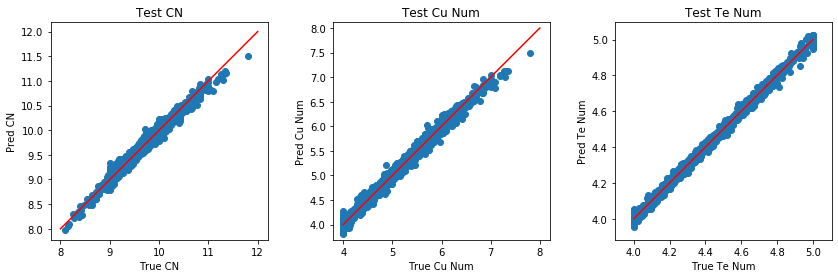

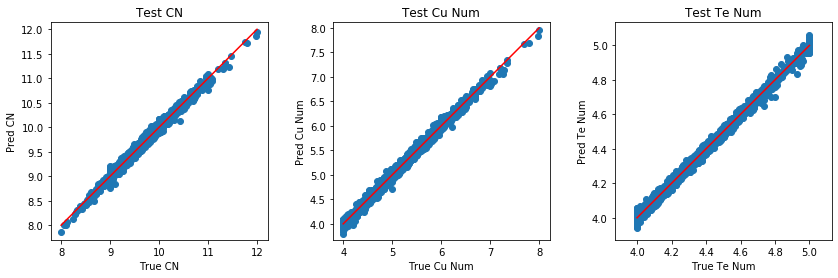

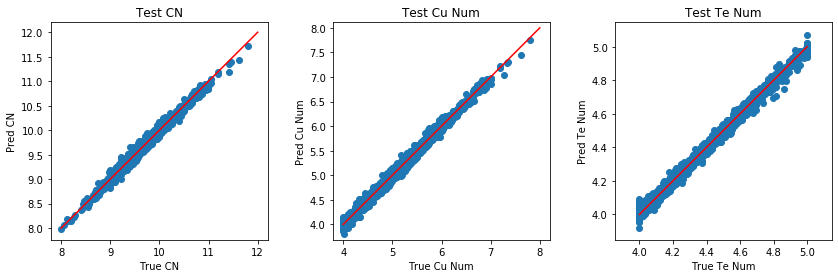

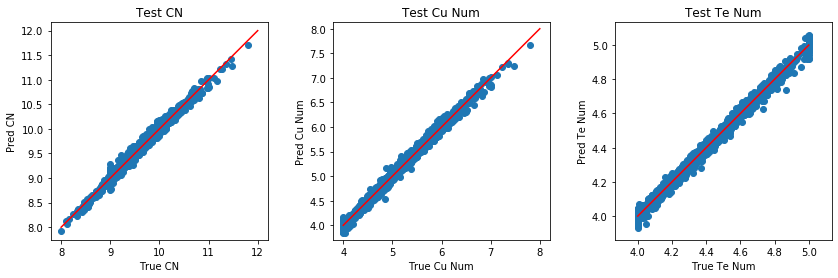

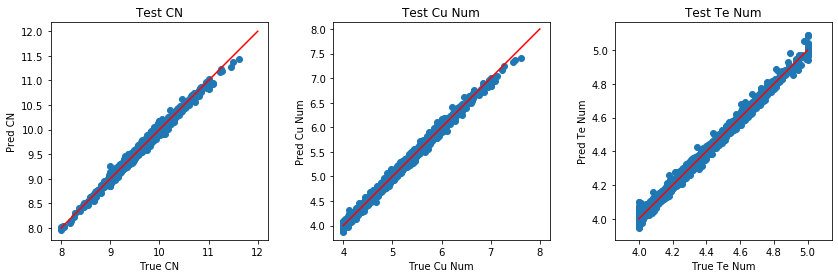

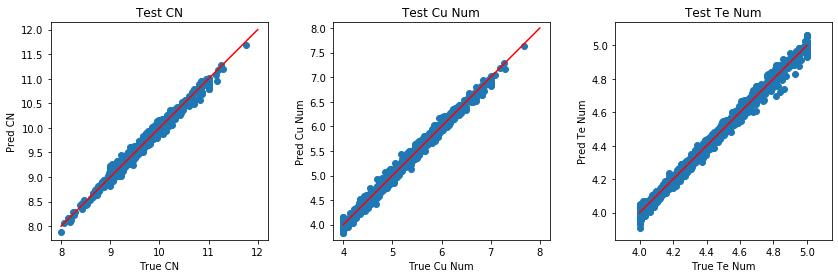

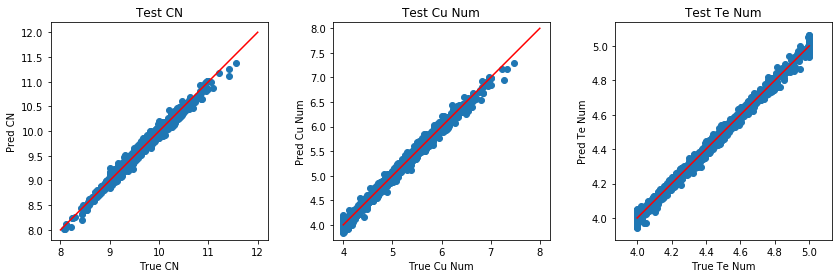

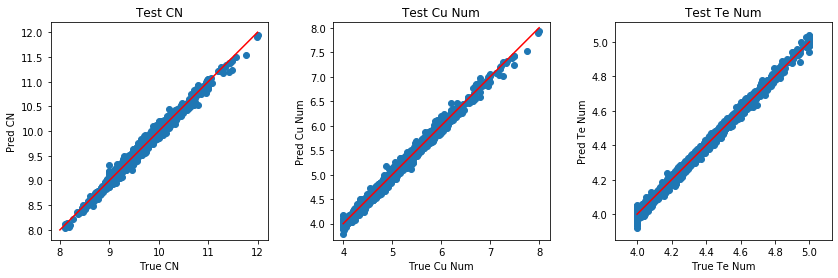

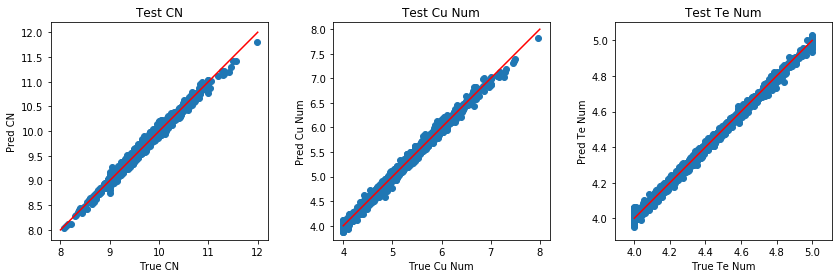

In [13]:
MLP_per_set_size_2(df, size_list, rmse_CN_master_list_2, score_CN_master_list_2, rmse_Cu_master_list_2, score_Cu_master_list_2, rmse_Te_master_list_2, score_Te_master_list_2)

In [14]:
print(rmse_CN_master_list_2)

[0.056094155000072365, 0.05796055079453918, 0.06408237465522974, 0.04930616650979081, 0.05077026015545315, 0.051248239806318166, 0.043657434049024134, 0.052785161729816905, 0.054731540725160545, 0.054026009853248375, 0.0514529025806026]


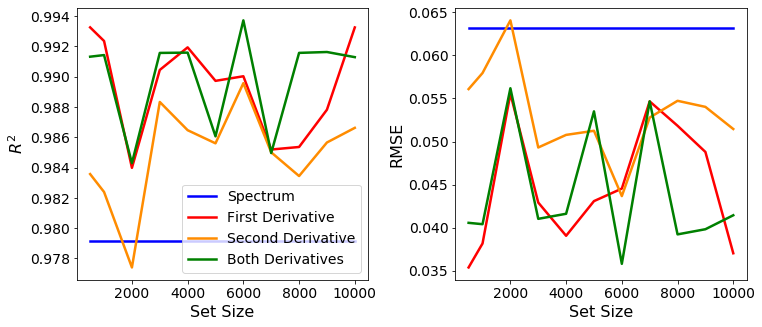

In [16]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, score_CN_master_list, c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, score_CN_master_list_1, c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, score_CN_master_list_2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, score_CN_master_list_1_2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, rmse_CN_master_list, c='blue', lw=2.5)
ax2.plot(size_list, rmse_CN_master_list_1, c='red', lw=2.5)
ax2.plot(size_list, rmse_CN_master_list_2, c='darkorange', lw=2.5)
ax2.plot(size_list, rmse_CN_master_list_1_2, c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

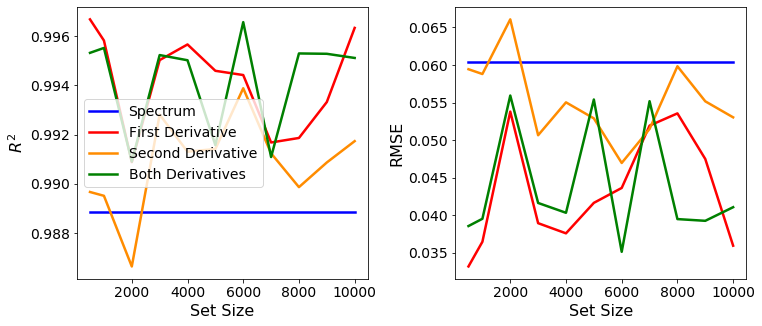

In [17]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, score_Cu_master_list, c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, score_Cu_master_list_1, c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, score_Cu_master_list_2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, score_Cu_master_list_1_2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, rmse_Cu_master_list, c='blue', lw=2.5)
ax2.plot(size_list, rmse_Cu_master_list_1, c='red', lw=2.5)
ax2.plot(size_list, rmse_Cu_master_list_2, c='darkorange', lw=2.5)
ax2.plot(size_list, rmse_Cu_master_list_1_2, c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

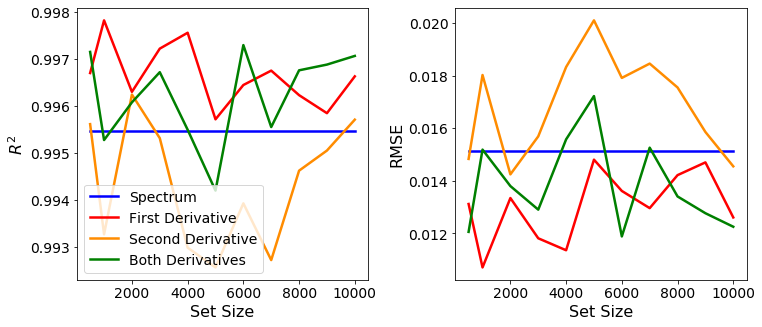

In [18]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, score_Te_master_list, c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, score_Te_master_list_1, c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, score_Te_master_list_2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, score_Te_master_list_1_2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, rmse_Te_master_list, c='blue', lw=2.5)
ax2.plot(size_list, rmse_Te_master_list_1, c='red', lw=2.5)
ax2.plot(size_list, rmse_Te_master_list_2, c='darkorange', lw=2.5)
ax2.plot(size_list, rmse_Te_master_list_1_2, c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()